# ML Design Pattern: Repeatable Splitting


## Reproducible ML: Maybe you shouldn't be using train_test_split

Reproducibility is critical for robust data science -- after all, it is a science.

But reproducibility in ML can be surprisingly difficult. 

The behaviour of your model doesn't only depend on your code, but also the underlying dataset that was used to train it.

Therefore, you need to keep tight control on the version of the dataset that was used for training any particular model.

A fundamental tenet of the ML workflow is splitting your data into training and testing sets. This helps evaluate the performance of your model on unseen data.

It is vitally important to be able to reproducibly split your data so you can effectively compare the performance of different model candidates, troubleshoot performance issues and  for colleagues to obtain the same results.

How you split your data can have a big effect on the end model performance and success of the model.

The common way to split your data is to use Sklearn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

Out of the box, the `train_test_split` function will randomly split your data. Each time you run the function you will get a different train and test split for your data. Not ideal for reproducibility.

"Ah!" you say. "I set the random seed so it is reproducible!". 

Fair point. Setting random seeds is an excellent idea and goes a long way to improve reproducibility and I would highly recommend setting random seeds for any functions which have probabilistic outputs. 

However, random seeds might not be enough to ensure reproducibility. In this post I will explain why the `train_test_split` with random seed does not always guarantee reproducibility and *transparency*.


<!-- ML is experimental and iterative, you need to be able to keep as many variables constant as possible. That includes which datapoints are used for training and which are used for testing. -->

<!-- - The crux, why is this important?: For reproducibility you want to ensure the data that was used to train a model remains consistent when you go to retrain it. This helps comparison of performance and debugging.
- Particularly if you need to retrain your model in the future (i.e. it is not just a one off). -->

## What is the problem with train_test_split?

**Setting the random reed only guarantees reproducible splits if the underlying data does not change when retraining the model.**

The splits are sensitive to the *ordering* of the data. If your dataset is shuffled or amended in any way (e.g. new data is added), the data will be split differently. This means datapoints that were in the original training set might now end up in the test set and visa versa.

Therefore, for the same dataset you can get different splits depending on how the rows in the dataset are ordered. This is not a very robust solution. Even if one datapoint is removed in the future or if the order of two rows are switched, you will get a completely different training and test split.

Let's demonstrate the issue with a simple demo.

We will first download an example dataset from skelearn.datasets and create an 'index' column to uniquely identify each row.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from sklearn.datasets import load_breast_cancer

import pandas as pd

# download an example dataset
data = load_breast_cancer()
df = pd.DataFrame(data["data"], columns=data["feature_names"])

# create an 'index' column to use to uniquely identify each row
df = df.reset_index(drop=False)

df.head()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<IPython.core.display.Javascript object>

Now let's split the data using Sklearn's `train_test_split` and then shuffle the dataframe and split the data again. We will set also the random state (seed).

In [3]:
from sklearn.model_selection import train_test_split

# set parameters
TEST_RATIO = 0.1
SEED = 42

# split into training and test using a random seed
x_train_skl, x_test_skl = train_test_split(df, test_size=TEST_RATIO, random_state=SEED)

# shuffle the orginal dataframe
df_shuffled = df.sample(frac=1)

# split the shuffled dataframe using the same random seed
x_train_skl_shuffled, x_test_skl_shuffled = train_test_split(
    df_shuffled, test_size=TEST_RATIO, random_state=SEED
)

<IPython.core.display.Javascript object>

Ideally the rows contained in the `x_test_skl` and `x_test_skl_shuffled` test sets should be identical. 

However, when we compare the row ids in each set they are different even though the random state (seed) was the same both times. Nothing in the data has changed, we have just shuffled the data.

In [4]:
# compare the row ids included in each test set.
# should return True
set(x_test_skl["index"]) == set(x_test_skl_shuffled["index"])

False

<IPython.core.display.Javascript object>

This highlights just how sensitive the `train_test_split` function is, even to ordering of the data.

## What are the consequences of using random seed when retraining the model with updated data?

The results of your model can vary significantly depending on how the data was split.

**If you don't have full control of the dataset, you cannot guarantee reproducibility**

It could be risky.

Can you be sure the dataset has not changed between training runs?

For example, if a colleague has removed an outlier data point or if new rows have been added. Your data splits will be completely different to your original splits.

You can use data versioning tools to help keep track of changes, however, that doesn't prevent your data splits changing. It would be better to protect against split changes in your code.


**Difficult to effectively compare models**

When comparing models we what to be able to control as many variables as possible. That should include which datapoints were used for training and testing.

Ideally when you split your data, the training and test data should follow the same data distributions and properties. However, there will inevitably be some statistical variation. 

If you data splits are significantly different between runs you might observe considerable differences in performance. For example if you have a couple of outliers which were in your training set for the original training run, but are now in your test set, you model performance might 'decline' as it could not predict outlier values in the test set as well as before.

**Difficult to debug**

Imagine you add some new data points to your dataset and retrain your model, but the performance of the model drops.

If you have used `train_test_split` you will have different splits. It would be difficult to understand whether the new data made the model worse, or, as highlighted in the previous point, it was just because the data was split differently.

## When might train_test_split not be appropriate?

**If you need to retrain your model with original + new data**

Adding new data to your existing data set will cause completely different splits. Your original data splits will not be reproducible.

If you are retraining the model with completely new data it isn't a problem as obviously all the training and test datapoints will be different.


**If you are retrieving your source data from an evolving data source**

For example a table in BigQuery which has new rows appended to it, or if you are working with filepaths as the input (e.g. images) and new images are being added to your source folder.

Or you cannot guarantee the order of the rows.

**You want to be able to reproducibly sample from the source dataset.**


**If there is a possibility of data leakage**

- which means certain cross-sections should *only* be in the training set or *only* in the test set
  - for example airline delays dataset
  
  
**If you have large datasets which do not fit in memory**



**If your production code will be rewritten in another language**
  - e.g. if using BQML or if your dataset moves location from csv to BigQuery table in the future
  - also if you are experimenting comparing a service like BQML to your custom Python model


## The Solution: Hashing

### What is hashing?

### Reasons to use hashing

**Improves development**

Working with colleagues in parallel on models

**Consistent splitting across raw and preprocessed data**

Can help with experimentation if you can ensure the same splits across different preprocessed datasets.


### How does it work for splitting data?

use unique id for the row and convert to an integer
split into buckets using modulus operation
select all values less than arbitrary value

### Farmhash

there are many hashing algorithms. example in sklearn, however, farmhash is another alternative which is easy to use and also supported (recommended) by BigQuery

we want lightweight...go through characteristics we want

why use fingerprint?

In [5]:
# FARMHASH SIMPLE DEMO
# show single value hashing results

import farmhash

hashed_value = farmhash.fingerprint64("hello")
print(hashed_value)

13009744463427800296


<IPython.core.display.Javascript object>

In [6]:
# assign a bucket using the modulus operation
hashed_value % 10

6

<IPython.core.display.Javascript object>

Therefore, our "hello" value would be assigned to bucket 6 of 10. 

## Splitting the data using Farmhash

In [7]:
# DEMO
# show distribution

<IPython.core.display.Javascript object>

### Considerations

- Will not produce exactly 10% of the dataset --> less of a problem for large datasets
- Which column should you use to hash?
- How many buckets to chose?


**Platform cross-compatibility quirks**

Having said that hashing is consistent across platforms. That is true to an extent.

While researching for this article, I tested to see if the dataset splits from my Python program were identical to a dataset stored in [BigQuery using SQL instead](https://towardsdatascience.com/ml-design-pattern-5-repeatable-sampling-c0ccb2889f39).

To my surprise, I found some edge cases where the results differed.

After a lot of head scratching, I came across a two quirks of BigQuery which were causing the issue:
1. [BigQuery does not support unsigned integers](https://stackoverflow.com/questions/51892989/how-does-bigquerys-farm-fingerprint-represent-a-64-bit-unsigned-int)
2. BigQuery, [C and C++ have different implementations for the modulus operation](https://stackoverflow.com/questions/3883004/the-modulo-operation-on-negative-numbers-in-python) compared to Python when it comes to negative numbers

The `farmhash.fingerprint64` method returns an *[unsigned](https://stackoverflow.com/questions/247873/signed-versus-unsigned-integers)* integer. Whereas the BigQuery `FARM_FINGERPRINT` function returns an `INT64` datatype. Therefore, BigQuery converts the farmhash output to a *signed* integer. The value of signed integer might be different to the original unsigned integer value and it might be negative.

Ok, can't we just convert our Python farmhash value to a signed integer?

Well, this leads to the second problem. In order to split the data into different buckets, we used the modulus operation. [Python and C (and BigQuery) have different implementations of the modulus operator](https://stackoverflow.com/questions/1907565/c-and-python-different-behaviour-of-the-modulo-operation#:~:text=Both%20variants%20are%20correct%2C%20however,same%20result%20as%20in%20Python.) which affects the results for negative numbers.

Therefore, if our signed integer is negative, the bucket it is assigned will differ depending on if we calculated it using Python's modulus operator (`%`) or BigQuery's `MOD` function. 

For example:

```
# in python
-1%10 = 9

# in BigQuery
MOD(-1,10) = -1
```

Does this mean hashing is not platform independent? 

Well, not really, just that you need to check how unsigned integers are treated and the how modulus of negative numbers is implemented.

We can fix our Python implementation to protect against these issues by converting the unsigned output of farmhash to a signed int and using a custom 'C-like' implementation of the modulus function.

```python
import numpy as np

def signed_hash_value(value:Any) -> int:
    """Convert unsigned hashed value to a signed int"""
    hashed_value = farmhash.fingerprint64(str(value))
    return np.uint64(hashed_value).astype("int64")
    
def c_mod(a:int, b:int)->int:
    """Modulus function implemented to behave like 'C' languages"""
    res = a % b
    if a < 0:
        res -= b
    return res

# this will give the same results in Python and BigQuery (and C-languages)
assigned_bucket = abs(c_mod(signed_hash_value,10))
```

[Note: the order of the abs and mod functions is important](https://mentin.medium.com/be-careful-with-abs-function-8e91c78715d5)

https://stackoverflow.com/questions/63341637/python-vs-bigquery-farmhash-sometimes-do-not-equal


### Alternatives to hashing

train test split, but could also create an additional column and explicitly assign a split (see Abishek Thakur - I remember that he like to do this). However, that creates an extra column of storage which takes up additional space and could be prone to someone changing it and it wouldn't be determininstic

### Other use cases for hashing

## Conclusion

## References and resources

## Tests

### More indepth code on BigQuery unsigned int debate

In [8]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [9]:
from typing import Any

import farmhash
import seaborn as sns
from sklearn.datasets import load_breast_cancer

import pandas as pd

# set parameters
TEST_RATIO = 0.1
SEED = 42
BUCKETS = 10

# download an example dataset
data = load_breast_cancer()
df = pd.DataFrame(data["data"], columns=data["feature_names"])

# create an 'index' column to use to uniquely identify each row
df = df.reset_index(drop=False)

df.head()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<IPython.core.display.Javascript object>

**Sklearn `train_test_split` method**

In [10]:
from sklearn.model_selection import train_test_split

# split into training and test using a random seed
x_train_skl, x_test_skl = train_test_split(df, test_size=TEST_RATIO, random_state=SEED)

# shuffle the orginal dataframe
df_shuffled = df.sample(frac=1)

# split the shuffled dataframe using the same random seed
x_train_skl_shuffled, x_test_skl_shuffled = train_test_split(
    df_shuffled, test_size=TEST_RATIO, random_state=SEED
)

<IPython.core.display.Javascript object>

Let's compare the test sets using the row index which uniquely identifies each row.

In [11]:
# compare the row ids included in each test set
set(x_test_skl["index"]) == set(x_test_skl_shuffled["index"])

False

<IPython.core.display.Javascript object>

The rows included in each test set are not the same. Even though we set the random seed to be the same.

This highlights how the sklearn `train_test_split` is sensitive to changes and ordering of the data.

If you can't guarantee the order of the data will be the same each time, or if you are retraining on a dataset which contains the original data plus some new data, your data splits will be different even if you set the random seed.

**Hashing method**

For the hashing method we will need to create our own functions.

We need to...

In [12]:
def hash_value(value: Any) -> int:
    """convert a value into a hashed value"""
    return farmhash.fingerprint64(str(value))


def convert_hash_to_bucket(hashed_value: int, total_buckets: int) -> int:
    """assign a bucket based off the hash value"""
    return abs(hashed_value % total_buckets)


def test_set_check(bucket: int):
    """check if the bucket should be included in the test set"""
    return bucket < TEST_RATIO * BUCKETS


def assign_hash_bucket(value: Any) -> int:
    """assign a bucket to an input value using hashing algorithm"""
    hashed_value = hash_value(value)
    bucket = convert_hash_to_bucket(hashed_value, total_buckets=BUCKETS)
    return bucket


def hash_train_test_split(
    df: pd.DataFrame, split_col: str, approx_test_ratio: float
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Split the data into a training and test set based of a specific column

    Args:
        df (pd.DataFrame): original dataset
        split_col (str): name of the column to use for hashing algo
        approx_test_ratio (float): between 0-1. This is an approximate ratio
           as the hashing algo will not necessarily provide a uniform bucket
           distribution

    Returns:
        tuple: Two dataframes, first is the training set and second is the
           test set
    """
    df["buckets"] = df[split_col].apply(assign_hash_bucket)
    in_test_set = df["buckets"].apply(test_set_check)
    return df[~in_test_set], df[in_test_set]

<IPython.core.display.Javascript object>

In [13]:
# create a training and test set from original dataset using hashing method
x_train_hash, x_test_hash = hash_train_test_split(
    df, split_col="index", approx_test_ratio=TEST_RATIO
)


# create a training and test set from shuffled dataset using hashing method
x_train_hash, x_test_hash_shuffled = hash_train_test_split(
    df_shuffled, split_col="index", approx_test_ratio=TEST_RATIO
)

<IPython.core.display.Javascript object>

In [14]:
# compare the row ids included in each test set
set(x_test_hash["index"]) == set(x_test_hash_shuffled["index"])

True

<IPython.core.display.Javascript object>

Problem solved! Even though the underlying dataframe has been shuffled, the same row ids appear in the test dataset regardless.

Note, however, with the hashing method your data will not necessarily be split exactly by the ratio you specify. The larger your dataset, the less of an issue this will be.

In [15]:
total_records = len(df)
target_records = int(total_records * TEST_RATIO)
hash_test_set_records = len(x_test_hash)

target_records, hash_test_set_records

(56, 46)

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Count'>

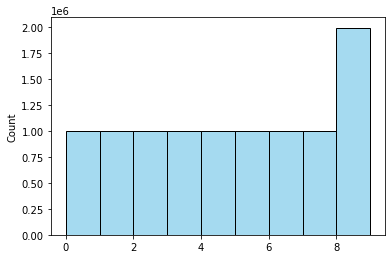

<IPython.core.display.Javascript object>

In [16]:
values = [farmhash.fingerprint64(str(i)) % 10 for i in range(1_000_000_0)]
sns.histplot(
    data=values,
    color="skyblue",
    binwidth=1,
)

In [17]:
from collections import Counter

Counter(values)

Counter({5: 1001297,
         9: 998108,
         1: 998962,
         3: 1000155,
         7: 999531,
         8: 999567,
         2: 1000679,
         6: 1000185,
         0: 1000657,
         4: 1000859})

<IPython.core.display.Javascript object>

In [18]:
import farmhash

dir(farmhash)

abs(farmhash.fingerprint64("abc") % 10)

5

<IPython.core.display.Javascript object>

In [20]:
import numpy as np

n = np.uint64(farmhash.fingerprint64("1footrue")).astype("int64")
n % 10

9

<IPython.core.display.Javascript object>

In [21]:
def c_mod(a, b):
    res = a % b
    if a < 0:
        res -= b
    return res


c_mod(n, 10)

-1

<IPython.core.display.Javascript object>

In [22]:
abs(c_mod(-1541654101129638711, 10))

1

<IPython.core.display.Javascript object>

In [24]:
abs(-1541654101129638711) % 10

1

<IPython.core.display.Javascript object>

In [25]:
s = -1541654101129638711
abs(s % 10)

9

<IPython.core.display.Javascript object>

In [26]:
t = np.uint64(farmhash.fingerprint64("1footrue")).astype("int64")
abs(t % 10)

9

<IPython.core.display.Javascript object>

In [27]:
-11 % 10

9

<IPython.core.display.Javascript object>

In [28]:
-1541654101129638711 % 10

9

<IPython.core.display.Javascript object>

SHOW MORE INFO ON HOW THE BUCKET DISTRIBUTIONS HAPPEN - E.G. HISTOGRAM PLOTS?

### Resources

https://towardsdatascience.com/advanced-random-sampling-in-bigquery-sql-7d4483b580bb